# Import Library

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.precision',2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:.2f}'.format

# Data Preparation

## Get Data

In [5]:
df = pd.read_parquet('data transaksi.parquet')
df.sort_values('period')

,period,receive_no,cust_id,product_id,quantity,amount,store_id
705483,2023-01-01,RD0.1.20230101.45TO,C000080840,P11212,1.00,419930.00,T070
178415,2023-01-01,R34.1.20230101.75TO,C000117915,P04601,1.00,109900.00,T026
178414,2023-01-01,R34.1.20230101.26TO,C000082404,P26242,1.00,100000.00,T026
178413,2023-01-01,R34.1.20230101.125TO,C000117974,P00422,1.00,26320.00,T026
980560,2023-01-01,R58.1.20230101.57TO,C000177424,P11301,3.00,149850.00,T047
...,...,...,...,...,...,...,...
1225488,2024-06-30,R45.2.20240630.60TO,C000155779,P21172,1.00,251100.00,T037
1225487,2024-06-30,R45.2.20240630.38TO,C000155697,P08997,1.00,140000.00,T037
1225486,2024-06-30,R45.2.20240630.38TO,C000155697,P14913,1.00,125970.00,T037
681252,2024-06-30,R17.1.20240630.33TO,C000067237,P19419,1.00,499950.00,T013


In [6]:
df['cust_id'].nunique()

149427

## Preprocessing Data

In [11]:
# Check missing value
df.isna().sum()

period        0
receive_no    0
cust_id       0
product_id    0
quantity      0
amount        0
store_id      0
dtype: int64

In [12]:
# Make Sure Format
df['period'] = pd.to_datetime(df['period'])
df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')

# Take out canceled/return transaction
data_clean = df[~df['receive_no'].str.contains(r'\.0\.', regex=True)]

In [13]:
data_clean.sort_values('period')

,period,receive_no,cust_id,product_id,quantity,amount,store_id
94278,2023-01-01,R05.1.20230101.38TO,C000023280,P11026,1.00,159920.00,T004
1028979,2023-01-01,R43.1.20230101.47TO,C000148319,P13308,1.00,827100.00,T035
1028980,2023-01-01,R43.1.20230101.47TO,C000148319,P13307,1.00,827100.00,T035
1028982,2023-01-01,R43.1.20230101.19TO,C000148320,P26016,1.00,33900.00,T035
906411,2023-01-01,R25.2.20230101.33TO,C000031806,P11387,1.00,81870.00,T019
...,...,...,...,...,...,...,...
236637,2024-06-30,R65.1.20240630.124TO,C000010235,P07146,1.00,21200.00,T053
236636,2024-06-30,R65.1.20240630.124TO,C000010235,P26016,3.00,69801.00,T053
1071105,2024-06-30,R59.1.20240630.67TO,C000141534,P07143,1.00,21200.00,T048
237312,2024-06-30,R05.78.20240630.14TO,C000031205,P26392,1.00,17000.00,T004


In [17]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1353835 entries, 0 to 1356921
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   period      1353835 non-null  datetime64[ns]
 1   receive_no  1353835 non-null  object        
 2   cust_id     1353835 non-null  object        
 3   product_id  1353835 non-null  object        
 4   quantity    1353835 non-null  float64       
 5   amount      1353835 non-null  float64       
 6   store_id    1353835 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 82.6+ MB


# BG/NBD Model

In [21]:
# For BG/NBD and Gamma-Gamma Model (Probability Prediction)
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data, summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix, \
    plot_period_transactions, plot_history_alive, \
    plot_cumulative_transactions, plot_calibration_purchases_vs_holdout_purchases
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Train-Test

In [23]:
# Size of the data
total_days = data_clean['period'].max() - data_clean['period'].min()
total_days

Timedelta('546 days 00:00:00')

In [24]:
%%time

# number of days for test(holdout)
t_holdout = 164

# end date of data
max_date = data_clean['period'].max()
print('End Date of Data: ', max_date)

# end date of calibration
max_cal_date = max_date - timedelta(days=t_holdout)
print('End Date of Calibration:', max_cal_date)

# Spliting data to train(calibration) and test(holdout)
df_train_test = calibration_and_holdout_data(
        transactions = data_clean,
        customer_id_col = 'cust_id',
        datetime_col = 'period',
        monetary_value_col = 'amount',
        calibration_period_end = max_cal_date,
        observation_period_end = max_date,
        freq = 'D'
)

pd.options.display.float_format = '{:,.0f}'.format
df_train_test

End Date of Data:  2024-06-30 00:00:00
End Date of Calibration: 2024-01-18 00:00:00
CPU times: total: 49.5 s
Wall time: 49.7 s


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
cust_id,,,,,,,
C000000001,2,49,320,"350,415",0,0,164
C000000002,4,181,319,"449,367",1,"107,078",164
C000000003,11,358,375,"1,645,450",1,"312,107",164
C000000004,1,91,319,"33,900",0,0,164
C000000005,13,310,352,"2,909,369",4,"499,510",164
...,...,...,...,...,...,...,...
C000236494,0,0,26,0,0,0,164
C000236572,0,0,25,0,0,0,164
C000236671,0,0,19,0,0,0,164


In [27]:
df_train_test.describe()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,"111,813","111,813","111,813","111,813","111,813","111,813","111,813"
mean,2,78,189,"277,373",1,"105,534",164
std,4,114,130,"659,271",2,"215,419",0
min,0,0,0,0,0,0,164
25%,0,0,54,0,0,0,164
50%,0,0,191,0,0,0,164
75%,2,138,315,"379,720",2,"166,411",164
max,122,382,382,"78,995,000",100,"24,374,925",164


### Train BG/NBD

In [29]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(
        frequency = df_train_test["frequency_cal"],
        recency = df_train_test["recency_cal"],
        T = df_train_test["T_cal"],
)

<lifetimes.BetaGeoFitter: fitted with 111813 subjects, a: 0.18, alpha: 50.78, b: 1.22, r: 0.56>

In [30]:
pd.options.display.float_format = '{:,.2f}'.format
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.56,0.00,0.55,0.57
alpha,50.78,0.49,49.83,51.74
a,0.18,0.00,0.17,0.19
b,1.22,0.04,1.15,1.29


<Figure size 1200x1200 with 0 Axes>

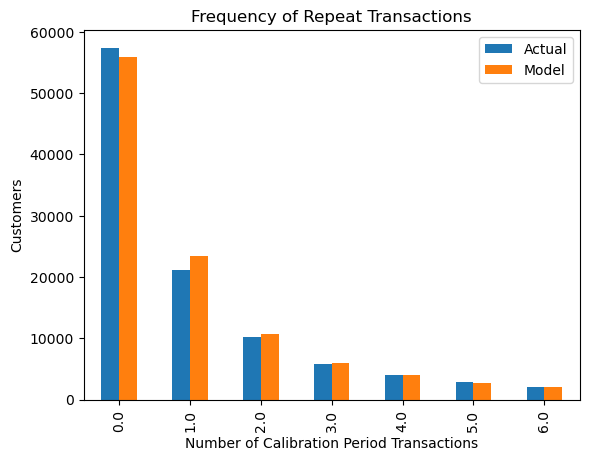

In [31]:
# Plot: actual vs predicted frequency of repeat transactions
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(bgf);

<Figure size 700x700 with 0 Axes>

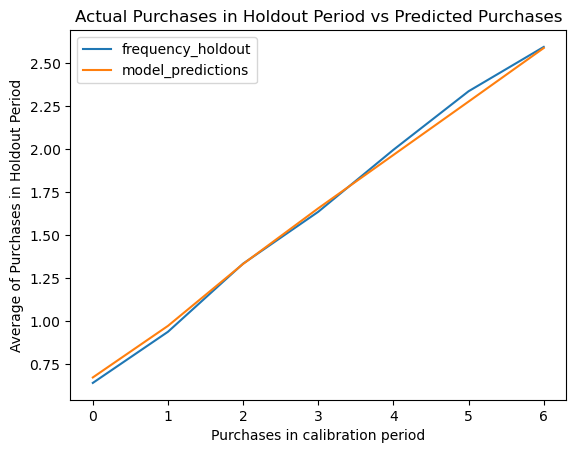

In [32]:
# Testing plot: actual vs predicted purchases
fig = plt.figure(figsize=(7, 7))
plot_calibration_purchases_vs_holdout_purchases(bgf, df_train_test);

In [33]:
# Predict purchases each customer for next 164 days
df_train_test['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    164, 
    df_train_test['frequency_cal'], 
    df_train_test['recency_cal'], 
    df_train_test['T_cal'])

### Evaluation

In [35]:
# RMSE
print('RMSE: ', mean_squared_error(df_train_test['frequency_holdout'], df_train_test['predicted_purchases'])**(1/2))

# MAE
print('MAE', mean_absolute_error(df_train_test['frequency_holdout'], df_train_test['predicted_purchases']))

# SMAPE
def smape(y_true, y_pred):
    difference = abs(y_true - y_pred)
    denominator = (abs(y_true) + abs(y_pred))/2
    return np.mean(np.where(denominator==0, 0, difference/denominator))

print(f"SMAPE: {smape(df_train_test['frequency_holdout'], df_train_test['predicted_purchases']):.2f}%")

RMSE:  1.860471773123147
MAE 1.1381289327167428
SMAPE: 1.37%


## Apply to All Data

In [45]:
# Summary recency, frequency, T, monetary value each customer
summ_rft = summary_data_from_transaction_data(
        transactions = data_clean,
        customer_id_col = 'cust_id',
        datetime_col = 'period',
        monetary_value_col = 'amount',
        observation_period_end = max_date,
        freq = "D")

summ_rft

,frequency,recency,T,monetary_value
cust_id,,,,
C000000001,2.00,49.00,484.00,"350,415.00"
C000000002,5.00,475.00,483.00,"402,325.00"
C000000003,12.00,391.00,539.00,"1,612,365.17"
C000000004,1.00,91.00,483.00,"33,900.00"
C000000005,17.00,496.00,516.00,"3,165,066.06"
...,...,...,...,...
C000236808,0.00,0.00,26.00,0.00
C000236811,0.00,0.00,21.00,0.00
C000236816,0.00,0.00,15.00,0.00


In [46]:
# Fit BG/NBD Model to All Data
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(
        frequency = summ_rft['frequency'],
        recency = summ_rft['recency'],
        T = summ_rft['T']
)

<lifetimes.BetaGeoFitter: fitted with 149427 subjects, a: 0.15, alpha: 63.07, b: 0.92, r: 0.70>

In [47]:
pd.options.display.float_format = '{:,.2f}'.format
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.70,0.00,0.69,0.71
alpha,63.07,0.47,62.16,63.98
a,0.15,0.00,0.14,0.15
b,0.92,0.02,0.88,0.97


### Frequency-Recency Matrix

In [49]:
max_freq = int(summ_rft['frequency'].max())
max_T = int(summ_rft['T'].max())
max_rec = int(summ_rft['recency'].max())

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

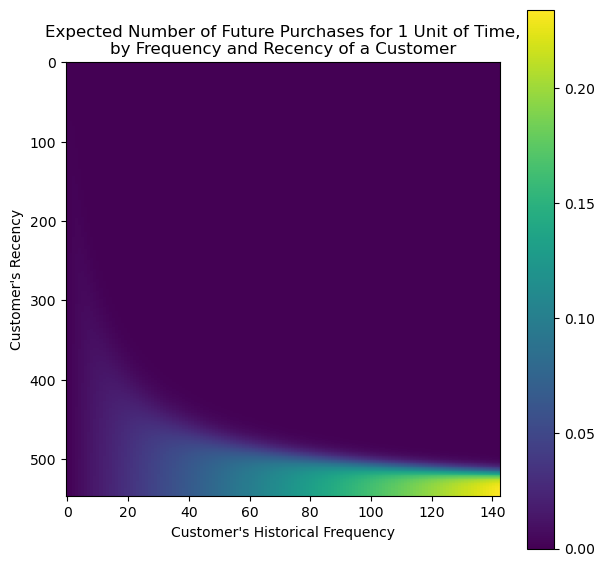

In [50]:
# Frequency.max() 0 and recency.max()
fig = plt.figure(figsize=(7, 7))
plot_frequency_recency_matrix(
        model = bgf,
        T = 1,
        max_frequency = max_freq,
        max_recency = max_rec
)

### Churn Matrix

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

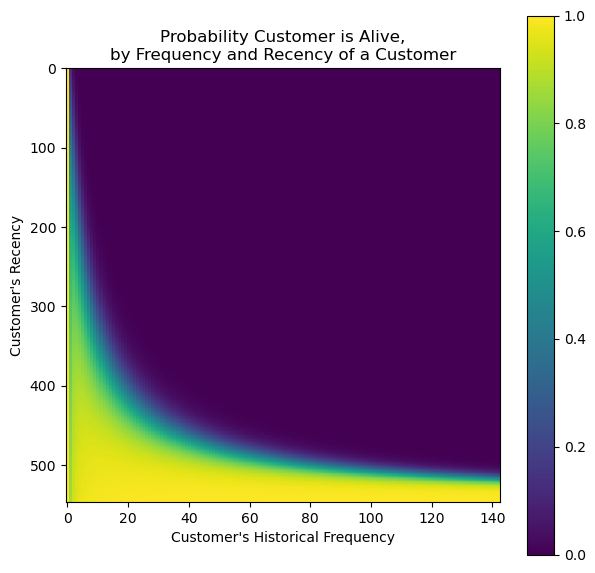

In [52]:
# Frequency.max() and recency.max()
fig = plt.figure(figsize=(7,7))
plot_probability_alive_matrix(
                    model = bgf,
                    max_frequency = max_freq,
                    max_recency = max_rec)

### Predicted Purchases

In [55]:
# Predict purchases each customer for next 90 days / 3 months
summ_rft['predict_purchases_next_3_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(90, summ_rft['frequency'], summ_rft['recency'], summ_rft['T'])
summ_rft

,frequency,recency,T,monetary_value,predict_purchases_next_3_months
cust_id,,,,,
C000000001,2.00,49.00,484.00,"350,415.00",0.07
C000000002,5.00,475.00,483.00,"402,325.00",0.90
C000000003,12.00,391.00,539.00,"1,612,365.17",1.30
C000000004,1.00,91.00,483.00,"33,900.00",0.12
C000000005,17.00,496.00,516.00,"3,165,066.06",2.68
...,...,...,...,...,...
C000236808,0.00,0.00,26.00,0.00,0.65
C000236811,0.00,0.00,21.00,0.00,0.69
C000236816,0.00,0.00,15.00,0.00,0.73


### Probability Alive/Churn

In [57]:
# Probability alive/churn each customer 
prob_alive = bgf.conditional_probability_alive(
                frequency = summ_rft['frequency'],
                recency = summ_rft['recency'],
                T = summ_rft['T'])

summ_rft['prob_alive'] = prob_alive
summ_rft

,frequency,recency,T,monetary_value,predict_purchases_next_3_months,prob_alive
cust_id,,,,,,
C000000001,2.00,49.00,484.00,"350,415.00",0.07,0.15
C000000002,5.00,475.00,483.00,"402,325.00",0.90,0.97
C000000003,12.00,391.00,539.00,"1,612,365.17",1.30,0.69
C000000004,1.00,91.00,483.00,"33,900.00",0.12,0.42
C000000005,17.00,496.00,516.00,"3,165,066.06",2.68,0.98
...,...,...,...,...,...,...
C000236808,0.00,0.00,26.00,0.00,0.65,1.00
C000236811,0.00,0.00,21.00,0.00,0.69,1.00
C000236816,0.00,0.00,15.00,0.00,0.73,1.00


In [58]:
churned_pct = (summ_rft['prob_alive'] < 0.5).mean() * 100
print(f"{churned_pct:.2f}% pelanggan diperkirakan sudah churn.")

9.05% pelanggan diperkirakan sudah churn.


# Gamma-Gamma Model

In [60]:
# Filter customer with frequency > 0 and  monetary value > 0
summ_rftv = summ_rft[(summ_rft['frequency']>0) & (summ_rft['monetary_value']>0)]

## Train Gamma-Gamma

In [62]:
# Fitting the Gamma-Gamma Model
ggf = GammaGammaFitter(penalizer_coef = 0.001)
ggf.fit(
        frequency = summ_rftv['frequency'],
        monetary_value = summ_rftv['monetary_value'],)

<lifetimes.GammaGammaFitter: fitted with 99104 subjects, p: 7.88, q: 0.12, v: 7.76>

In [63]:
pd.options.display.float_format = '{:,.2f}'.format
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,7.88,0.05,7.78,7.98
q,0.12,0.00,0.12,0.12
v,7.76,0.05,7.65,7.86


## Predict Average Value

In [65]:
# Estimate the average value each customer based on frequency and monetary
summ_rftv['exp_avg_value'] = ggf.conditional_expected_average_profit(
                summ_rftv["frequency"],
                summ_rftv["monetary_value"])

summ_rftv

,frequency,recency,T,monetary_value,predict_purchases_next_3_months,prob_alive,exp_avg_value
cust_id,,,,,,,
C000000001,2.00,49.00,484.00,"350,415.00",0.07,0.15,"371,121.11"
C000000002,5.00,475.00,483.00,"402,325.00",0.90,0.97,"411,508.62"
C000000003,12.00,391.00,539.00,"1,612,365.17",1.30,0.69,"1,627,496.91"
C000000004,1.00,91.00,483.00,"33,900.00",0.12,0.42,"38,165.75"
C000000005,17.00,496.00,516.00,"3,165,066.06",2.68,0.98,"3,185,975.11"
...,...,...,...,...,...,...,...
C000236657,1.00,5.00,33.00,"304,900.00",1.15,0.78,"343,196.81"
C000236687,1.00,3.00,22.00,"262,700.00",1.34,0.80,"295,697.51"
C000236691,1.00,1.00,23.00,"416,900.00",1.30,0.79,"469,261.31"


## Evaluation

In [67]:
# RMSE
rmse = np.sqrt(mean_squared_error(summ_rftv['monetary_value'], summ_rftv['exp_avg_value']))
print(f"RMSE: {rmse:.3f}")

# MAE
mae = mean_absolute_error(summ_rftv['monetary_value'], summ_rftv['exp_avg_value'])
print(f"MAE: {mae:.3f}")

# Hitung MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(summ_rftv['monetary_value'], summ_rftv['exp_avg_value'])
print(f"MAPE: {mape:.2f}%")

RMSE: 84783.851
MAE: 35727.345
MAPE: 7.08%


## Predict CLV

In [72]:
# Calculating CLV

# Monthly discount rate
disc_yearly = 0.05
disc_monthly = (1 + disc_yearly)**(1/12) - 1

time_in_months = 3 # in months

summ_rftv['predicted_clv'] = ggf.customer_lifetime_value(
    bgf, 
    summ_rftv['frequency'], 
    summ_rftv['recency'], 
    summ_rftv['T'], 
    summ_rftv['monetary_value'],
    time=time_in_months, 
    freq='D',
    discount_rate=disc_monthly
)

summ_rftv

,frequency,recency,T,monetary_value,predict_purchases_next_3_months,prob_alive,exp_avg_value,predicted_clv
cust_id,,,,,,,,
C000000001,2.00,49.00,484.00,"350,415.00",0.07,0.15,"371,121.11","24,482.43"
C000000002,5.00,475.00,483.00,"402,325.00",0.90,0.97,"411,508.62","366,562.43"
C000000003,12.00,391.00,539.00,"1,612,365.17",1.30,0.69,"1,627,496.91","2,092,337.45"
C000000004,1.00,91.00,483.00,"33,900.00",0.12,0.42,"38,165.75","4,384.24"
C000000005,17.00,496.00,516.00,"3,165,066.06",2.68,0.98,"3,185,975.11","8,457,204.71"
...,...,...,...,...,...,...,...,...
C000236657,1.00,5.00,33.00,"304,900.00",1.15,0.78,"343,196.81","393,051.64"
C000236687,1.00,3.00,22.00,"262,700.00",1.34,0.80,"295,697.51","392,664.37"
C000236691,1.00,1.00,23.00,"416,900.00",1.30,0.79,"469,261.31","607,298.28"


# Dataframe CLV

In [74]:
summ_value = summ_rftv.reset_index()[['cust_id','exp_avg_value','predicted_clv']].drop_duplicates()
summ_rft = summ_rft.reset_index()[['cust_id','predict_purchases_next_3_months','prob_alive']].drop_duplicates()

df_clv = pd.merge(summ_rft, summ_value, how='left', on='cust_id')
df_clv

,cust_id,predict_purchases_next_3_months,prob_alive,exp_avg_value,predicted_clv
0,C000000001,0.07,0.15,"371,121.11","24,482.43"
1,C000000002,0.90,0.97,"411,508.62","366,562.43"
2,C000000003,1.30,0.69,"1,627,496.91","2,092,337.45"
3,C000000004,0.12,0.42,"38,165.75","4,384.24"
4,C000000005,2.68,0.98,"3,185,975.11","8,457,204.71"
...,...,...,...,...,...
149422,C000236808,0.65,1.00,NaN,NaN
149423,C000236811,0.69,1.00,NaN,NaN
149424,C000236816,0.73,1.00,NaN,NaN
149425,C000236821,0.82,1.00,NaN,NaN


In [75]:
# Calculate exp_avg_value and predicted_clv manual for customer with freq = 1
current_date = data_clean['period'].max() + dt.timedelta(days=1)

df_agg = data_clean.groupby('cust_id').agg(
    frequency = ('period', 'nunique'),
    first_trx = ('period', 'min'),
    last_trx = ('period', 'max'),
    sales = ('amount','sum')
).reset_index()

df_agg = pd.merge(df_agg, df_clv, how='left', on='cust_id')

df_agg['recency'] = (current_date - df_agg['last_trx']).dt.days
df_agg['length'] = (df_agg['last_trx'] - df_agg['first_trx']).dt.days
df_agg['monetary'] = df_agg['sales'] / df_agg['frequency']

df_agg['exp_avg_value'] = df_agg['exp_avg_value'].fillna(df_agg['monetary'])

discount_factor = 1 / (1 + disc_monthly)**time_in_months

df_agg['predicted_clv_manual'] = (
    df_agg['predict_purchases_next_3_months'] *
    df_agg['exp_avg_value'] *
    discount_factor
)

df_agg['predicted_clv'].fillna(df_agg['predicted_clv_manual'], inplace=True)
df_agg.drop(columns=['predicted_clv_manual'], inplace=True)

# Apply to df_clv
need = df_agg.reset_index()[['cust_id','exp_avg_value','predicted_clv']].drop_duplicates().rename(columns={'exp_avg_value':'value_cluster','predicted_clv':'clv_cluster'})

df_clv = pd.merge(df_clv, need, how='left', on='cust_id')
df_clv['exp_avg_value'].fillna(df_clv['value_cluster'], inplace=True)
df_clv['predicted_clv'].fillna(df_clv['clv_cluster'], inplace=True)
df_clv.drop(columns=['value_cluster','clv_cluster'], inplace=True)

In [76]:
df_clv

,cust_id,predict_purchases_next_3_months,prob_alive,exp_avg_value,predicted_clv
0,C000000001,0.07,0.15,"371,121.11","24,482.43"
1,C000000002,0.90,0.97,"411,508.62","366,562.43"
2,C000000003,1.30,0.69,"1,627,496.91","2,092,337.45"
3,C000000004,0.12,0.42,"38,165.75","4,384.24"
4,C000000005,2.68,0.98,"3,185,975.11","8,457,204.71"
...,...,...,...,...,...
149422,C000236808,0.65,1.00,"549,500.00","352,431.29"
149423,C000236811,0.69,1.00,"234,950.00","159,054.82"
149424,C000236816,0.73,1.00,"1,031,420.00","748,180.28"
149425,C000236821,0.82,1.00,"171,914.00","139,741.20"


# K-Means

In [92]:
# For K-Means (Clustering)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

## LRFM (Last One Year)

In [95]:
# Lifecycle period
start_date = data_clean['period'].max() - pd.DateOffset(years=1)
data_lifecycle = data_clean[data_clean['period'] >= start_date]

In [97]:
# To get LRFM
df_agg = data_lifecycle.groupby('cust_id').agg(
    frequency = ('period', 'nunique'),
    first_trx = ('period', 'min'),
    last_trx = ('period', 'max'),
    sales = ('amount','sum')
).reset_index()

df_agg = pd.merge(df_agg, df_clv, how='left', on='cust_id')

df_agg['recency'] = (current_date - df_agg['last_trx']).dt.days
df_agg['length'] = (df_agg['last_trx'] - df_agg['first_trx']).dt.days
df_agg['monetary'] = df_agg['sales'] / df_agg['frequency']

In [99]:
df_agg.set_index('cust_id', inplace = True)
rfmt = df_agg[['frequency','recency','length','monetary','predicted_clv']]
rfmt

,frequency,recency,length,monetary,predicted_clv
cust_id,,,,,
C000000002,4,9,336,"461,663.75","366,562.43"
C000000003,5,149,195,"866,927.80","2,092,337.45"
C000000005,9,21,328,"3,519,025.89","8,457,204.71"
C000000006,1,190,0,"129,900.00","29,900.29"
C000000007,1,337,0,"20,000.00","42,009.94"
...,...,...,...,...,...
C000236808,1,27,0,"549,500.00","352,431.29"
C000236811,1,22,0,"234,950.00","159,054.82"
C000236816,1,16,0,"1,031,420.00","748,180.28"


## Clustering

In [102]:
# Normalized
scaler = StandardScaler()
rfmt_normalized = scaler.fit_transform(rfmt)

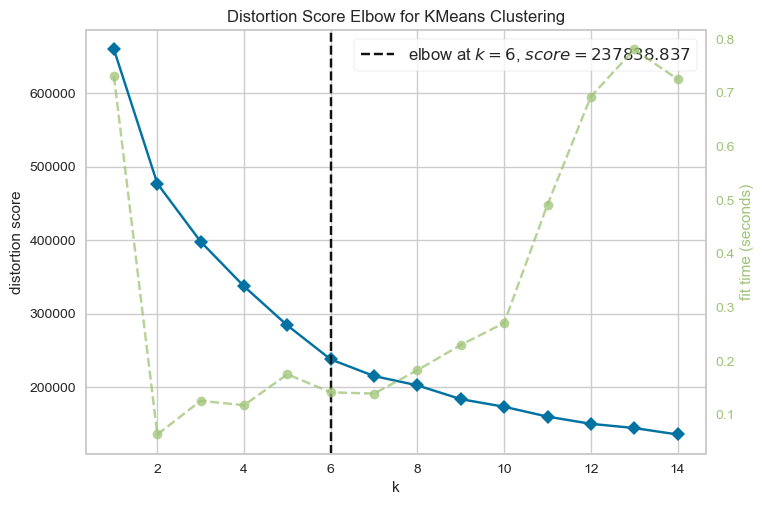

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [104]:
# Elbow method
kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k = (1,15))
visu.fit(rfmt_normalized)
visu.poof()

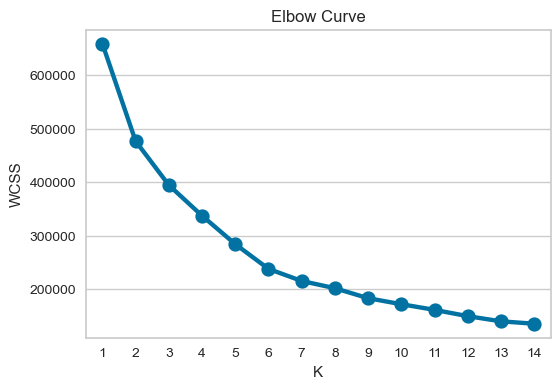

In [105]:
wcss = []

for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=12)
    kmeans.fit(rfmt_normalized)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(6, 4))
sns.pointplot(x=list(range(1, 15)), y=wcss)
plt.title('Elbow Curve')
plt.xlabel('K')
plt.ylabel('WCSS')
plt.show()

In [108]:
%%time

# Silhouette score
silhouette_avg_list = []
k_values_for_silhouette_score = []

for k in range(2, 14):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=12)
    cluster_labels = kmeans.fit_predict(rfmt_normalized)
    
    silhouette_avg = silhouette_score(rfmt_normalized, cluster_labels)
    k_values_for_silhouette_score.append(k)
    silhouette_avg_list.append(silhouette_avg)

CPU times: total: 1h 47min 32s
Wall time: 1h 3min 12s


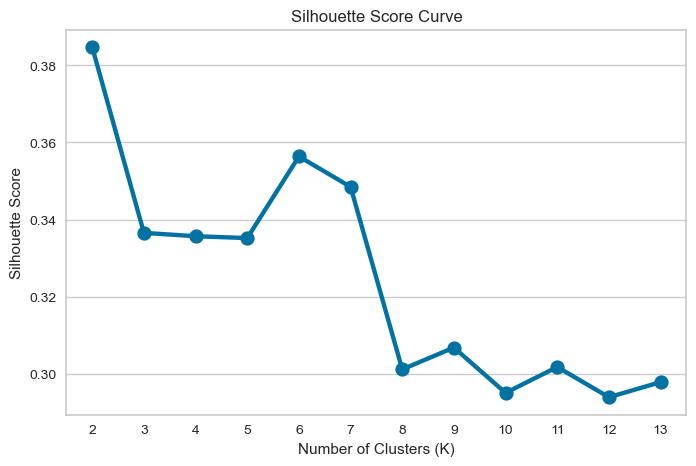

In [109]:
# Plot: silhouette score
plt.figure(figsize=(8, 5))
sns.pointplot(x=k_values_for_silhouette_score, y=silhouette_avg_list)
plt.title('Silhouette Score Curve')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

In [110]:
# Result silhouette score
for i, score in enumerate(silhouette_avg_list, start=2):
    print(f"k = {i} : {score}")

k = 2 : 0.3847208807142252
k = 3 : 0.3365332461211493
k = 4 : 0.335658476521413
k = 5 : 0.33518014096858645
k = 6 : 0.3563707019235513
k = 7 : 0.3484770780232227
k = 8 : 0.3010916121706386
k = 9 : 0.3067606999781597
k = 10 : 0.2949941725397093
k = 11 : 0.30171407614324003
k = 12 : 0.29386886919786737
k = 13 : 0.29778588267039674


In [107]:
# Use K=6 based on silhouette score
kmeans = KMeans(n_clusters=6,n_init='auto',random_state=12)
kmeans.fit(rfmt_normalized)

cluster_label = kmeans.labels_
rfmt_cluster = rfmt.assign(cluster=cluster_label)

In [110]:
rfmt_cluster.groupby('cluster').agg({
    'frequency':'median',
    'recency':'median',
    'length':'median',
    'monetary':'median',
    'predicted_clv':'median'
})

,frequency,recency,length,monetary,predicted_clv
cluster,,,,,
0,16.00,16.00,320.00,"565,878.00","2,121,158.47"
1,1.00,212.00,0.00,"371,810.00","83,059.07"
2,2.00,66.00,34.00,"323,010.00","192,625.59"
3,28.00,7.00,319.00,"4,888,388.84","25,780,069.35"
4,4.00,37.00,219.00,"416,735.50","442,251.11"
5,1.00,165.00,0.00,"2,573,813.33","816,843.23"


In [112]:
# Label segment
segment_names = {
    0: 'Rising Star',
    1: 'Inactive Shoppers',
    2: 'Exploratory Buyers',
    3: 'Top-Tier Loyalist',
    4: 'Regular Members',
    5: 'High-Value Sleepers'
}

rfmt_cluster['segment'] = rfmt_cluster['cluster'].map(segment_names)

In [114]:
# Label segment
segment_names = {
    0: 'Rising Star',
    1: 'Inactive Shoppers',
    2: 'Exploratory Buyers',
    3: 'Top-Tier Loyalist',
    4: 'Regular Members',
    5: 'High-Value Sleepers'
}

rfmt_cluster['segment'] = rfmt_cluster['cluster'].map(segment_names)

# Dataframe clustering
df_cluster = rfmt_cluster.reset_index()[['cust_id','frequency','recency','length','monetary','segment']].drop_duplicates()
df_cluster

,cust_id,frequency,recency,length,monetary,segment
0,C000000002,4,9,336,"461,663.75",Regular Members
1,C000000003,5,149,195,"866,927.80",Regular Members
2,C000000005,9,21,328,"3,519,025.89",Rising Star
3,C000000006,1,190,0,"129,900.00",Inactive Shoppers
4,C000000007,1,337,0,"20,000.00",Inactive Shoppers
...,...,...,...,...,...,...
131822,C000236808,1,27,0,"549,500.00",Exploratory Buyers
131823,C000236811,1,22,0,"234,950.00",Exploratory Buyers
131824,C000236816,1,16,0,"1,031,420.00",Exploratory Buyers
131825,C000236821,1,7,0,"171,914.00",Exploratory Buyers


# Dataframe Clustering

In [117]:
# Segment summary
summ_segmen = rfmt_cluster.reset_index().groupby('segment').agg({
    'cust_id':'nunique',
    'frequency':'median',
    'recency':'median',
    'length':'median',
    'monetary':'median',
    'predicted_clv':'median'
})

summ_segmen['%_cust'] = summ_segmen['cust_id'] / summ_segmen['cust_id'].sum()
summ_segmen = summ_segmen[['cust_id','%_cust','frequency','recency','length','monetary','predicted_clv']]

summ_segmen = summ_segmen.sort_values('cust_id',ascending=False)
summ_segmen

,cust_id,%_cust,frequency,recency,length,monetary,predicted_clv
segment,,,,,,,
Exploratory Buyers,50519,0.38,2.00,66.00,34.00,"323,010.00","192,625.59"
Inactive Shoppers,40465,0.31,1.00,212.00,0.00,"371,810.00","83,059.07"
Regular Members,32589,0.25,4.00,37.00,219.00,"416,735.50","442,251.11"
High-Value Sleepers,4317,0.03,1.00,165.00,0.00,"2,573,813.33","816,843.23"
Rising Star,3883,0.03,16.00,16.00,320.00,"565,878.00","2,121,158.47"
Top-Tier Loyalist,54,0.00,28.00,7.00,319.00,"4,888,388.84","25,780,069.35"


In [119]:
df_cluster = rfmt_cluster.reset_index()[['cust_id','frequency','recency','length','monetary','segment']].drop_duplicates()
df_cluster

,cust_id,frequency,recency,length,monetary,segment
0,C000000002,4,9,336,"461,663.75",Regular Members
1,C000000003,5,149,195,"866,927.80",Regular Members
2,C000000005,9,21,328,"3,519,025.89",Rising Star
3,C000000006,1,190,0,"129,900.00",Inactive Shoppers
4,C000000007,1,337,0,"20,000.00",Inactive Shoppers
...,...,...,...,...,...,...
131822,C000236808,1,27,0,"549,500.00",Exploratory Buyers
131823,C000236811,1,22,0,"234,950.00",Exploratory Buyers
131824,C000236816,1,16,0,"1,031,420.00",Exploratory Buyers
131825,C000236821,1,7,0,"171,914.00",Exploratory Buyers


# Interval Purchases

In [122]:
df_interval = data_clean[['cust_id','period']].drop_duplicates().sort_values(by=['cust_id', 'period'])

In [123]:
df_interval['next_purchase_date'] = df_interval.groupby('cust_id')['period'].shift(1)
df_interval.dropna(subset=['next_purchase_date'], inplace=True)
df_interval['interval_day'] = (df_interval['period'] - df_interval['next_purchase_date']).dt.days
df_periodicity = df_interval.groupby('cust_id')['interval_day'].median().reset_index()

# Merge with CLV and Cluster

In [127]:
df_final = df_clv.merge(df_cluster, how='left', on='cust_id').merge(df_periodicity, how='left', on='cust_id')
df_final['segment'] = df_final['segment'].fillna('Churn')
df_final['interval_day'] = df_final['interval_day'].fillna(0)

df_final = df_final.reindex(columns=['cust_id','segment','predict_purchases_next_3_months','prob_alive','predicted_clv','interval_day'])
df_final

,cust_id,segment,predict_purchases_next_3_months,prob_alive,predicted_clv,interval_day
0,C000000001,Churn,0.07,0.15,"24,482.43",24.50
1,C000000002,Regular Members,0.90,0.97,"366,562.43",56.00
2,C000000003,Regular Members,1.30,0.69,"2,092,337.45",25.00
3,C000000004,Churn,0.12,0.42,"4,384.24",91.00
4,C000000005,Rising Star,2.68,0.98,"8,457,204.71",25.00
...,...,...,...,...,...,...
149422,C000236808,Exploratory Buyers,0.65,1.00,"352,431.29",0.00
149423,C000236811,Exploratory Buyers,0.69,1.00,"159,054.82",0.00
149424,C000236816,Exploratory Buyers,0.73,1.00,"748,180.28",0.00
149425,C000236821,Exploratory Buyers,0.82,1.00,"139,741.20",0.00


# Save to Gsheet

In [130]:
df_final.to_csv('clv_segment.csv')